<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2023/TextureSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf './scattering_transform/'
!git clone 'https://github.com/jecampagne/scattering_transform.git' './scattering_transform/'

Cloning into './scattering_transform'...
remote: Enumerating objects: 1434, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1434 (delta 273), reused 353 (delta 245), pack-reused 1050
Receiving objects: 100% (1434/1434), 194.56 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (915/915), done.


In [4]:
import sys
sys.path.append('/content/scattering_transform/')

In [5]:
import numpy as np

In [6]:
import torch
torch.__version__

'2.0.1+cu118'

In [11]:
if not torch.cuda.is_available():
  print("Hum.... try to get a GPU at least a T4 or K80 if you want to rerun the nb")

In [13]:
# import scattering package
import scattering

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
import os
os.chdir("/content/drive/My Drive/Data4CoursSMallat")

In [20]:
ls

turbulence.png  WLconv_z0.50_0001r.npy


In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# in case of problem
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Introduction

This notebook intends to show how to use Scattering Transform to perform Microcanonical Models.

I will use the code originally setup by Sihao Cheng ([here is his github repo](https://github.com/SihaoCheng/scattering_transform))

You can also have a look at one of [his article](https://arxiv.org/pdf/2112.01288.pdf) that introduces some statistics used in this notebook.

Below is one of the figure of the above mentionned  aricle that remind the Scattering cascade of (wavelet convolutions, non-linearity (modulus), mean) as defined in 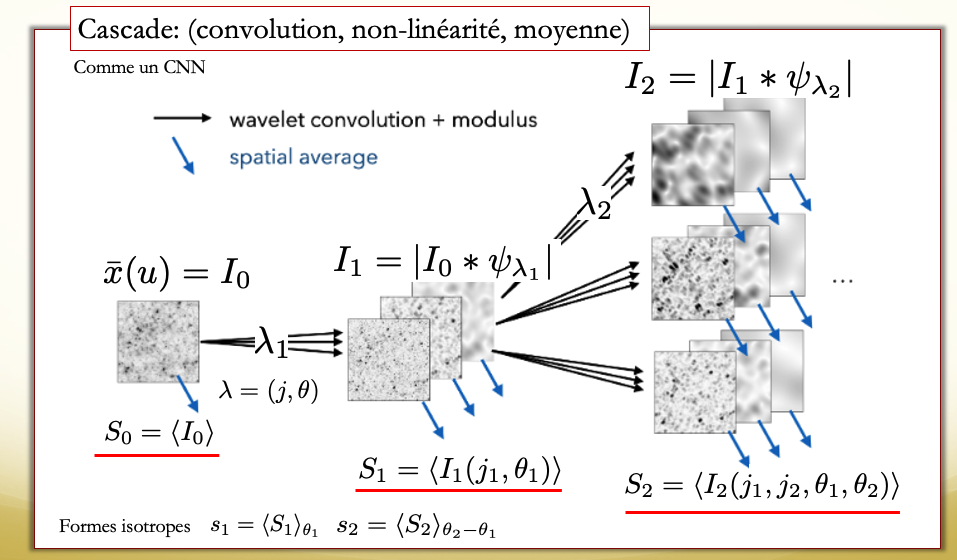




# Utils

In [14]:
def preprocess(x):
  if x.ndim != 3:
    x = x[np.newaxis]
  x = x.astype(np.float32)
  x = scattering.whiten(x)
  return x

In [15]:
def plot_coeffs(x, st_calc, ax=None, coefs=['S1_iso','s21','s22'], title=False):
  if ax is None:
    fig, ax = subplots(1,len(type)+1)

  id=0
  ax[0].imshow(x[0],vmin=-3,vmax=3,cmap='gray');
  ax[0].set_xticks([]);
  ax[0].set_yticks([]);
  s_mean = st_calc.scattering_coef(x)

  J = st_calc.J

  if   'S1_iso' in coefs:
    id += 1
    s1 = s_mean['S1_iso'].cpu().detach().numpy()
    ax[id].scatter(np.arange(J),np.log10(s1[0]));
    ax[id].plot(np.arange(J),np.log10(s1[0]));
    if title : 
      ax[id].set_title('S1_iso')

  if 's21' in coefs:
    id +=1
    s21 = s_mean['s21'].cpu().detach().numpy()
    #val=s_mean['s21'][:,mask.triu()==1].reshape(1,-1).mean()
    for j1 in range(J):
      data = np.zeros(J-j1)
      i=0
      for j2 in range(j1,J):
        data[i] = s21[0][j1,j2]/2**(j1-j2)
        i +=1
      ax[id].scatter(np.arange(J-j1)+j1*J,np.log10(data))
      ax[id].plot(np.arange(J-j1)+j1*J,np.log10(data))
      #ax[id].set_ylim([-1,1])
      if title : 
        ax[id].set_title('s21')
    
  if 's22' in coefs:
    id +=1
    s22 = s_mean['s22'].cpu().detach().numpy()
    for j1 in range(J):
      data = np.zeros(J-j1)
      i=0
      for j2 in range(j1,J):
        data[i] = s22[0][j1,j2]
        i +=1
      ax[id].scatter(np.arange(J-j1)+j1*J,np.log(data))
      ax[id].plot(np.arange(J-j1)+j1*J,np.log(data))
      #ax[id].set_ylim([-0.5,0.5])
      if title : 
        ax[id].set_title('s22')

In [38]:
def plot_syn(image_target,image_syn, title_syn='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    if vminmax is None:
        vmin = image_target.mean() - 3*image_target.std()
        vmax = image_target.mean() + 3*image_target.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image_target, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title("Original");
    img = axs[1].imshow(image_syn, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_syn);
    axs[0].set_xticks([]); axs[1].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());

# First use of a Map of Weak Lensing convergence among the MassiveNus dataset

The link to the repo is [here](http://astronomy.nmsu.edu/aklypin/SUsimulations/MassiveNuS/) and you can find additional information if you are interested [in this article by Liu et al.](https://arxiv.org/abs/1711.10524).

In [21]:
x = np.load('./WLconv_z0.50_0001r.npy')

In [22]:
image_target = preprocess(x)  # normalize 

In [26]:
image_target.mean(), image_target.std()

(1.3969839e-09, 1.0)

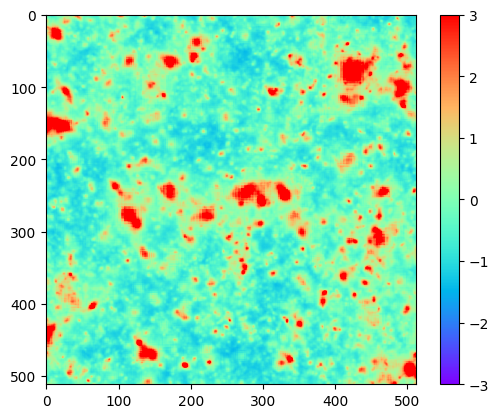

In [39]:
imshow(image_target[0],vmin=-3, vmax=3, cmap='rainbow'); colorbar();

## Let us try a synthesis using the Power Spectrum.

In [40]:
image_syn_ps = scattering.synthesis('', image_target, ps=True, seed=1)

input_size:  (1, 512, 512)
# of estimators:  9
max residual:  8.067739 , mean residual:  3.4671087
max residual:  4.656604e-08 , mean residual:  5.1740043e-09
time used:  5.8147194385528564 s


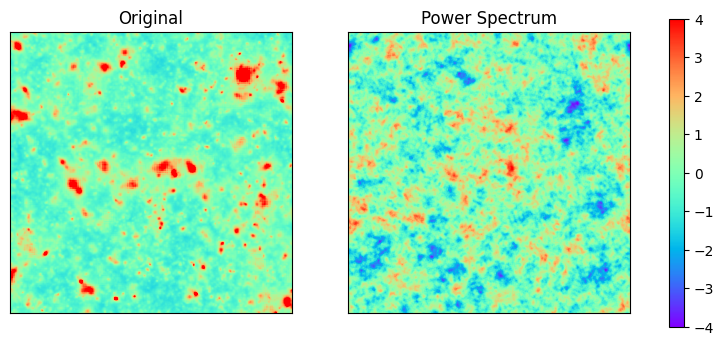

In [42]:
plot_syn(image_target[0],image_syn_ps[0], title_syn='Power Spectrum',vminmax=(-4,4), 
         colorbar=True, figsize=(10,4), cmap='rainbow')

Already by simple eyes inspection, we see that the synthetised image does not reflect the statistics of the original image. But we can display coefficients build from scattering coefficients: $S_1$  is more or less like the Power Spectrum, while $s_{21} = \langle S2/S1\rangle_{\theta_1,\theta_2}$ measures the sparsity of the image (greater means more sparse), and $s_{22} = \langle S_2\rangle_{\theta_2=\theta_1}/\langle S_2\rangle_{\theta_2\perp \theta_1}$ disantangles between more bubble-like to filament-like images.

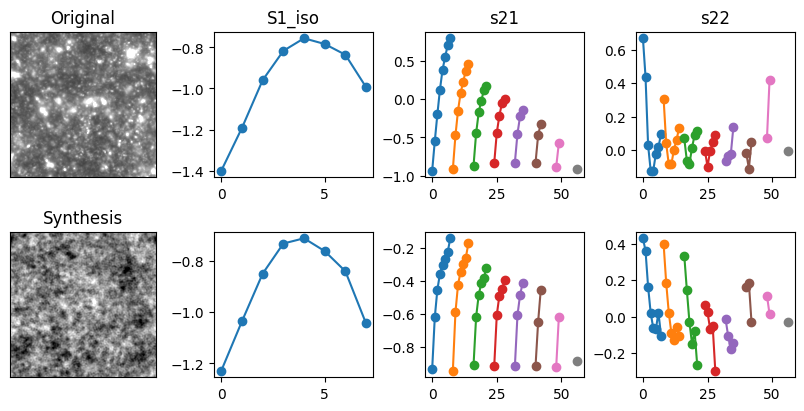

In [43]:
fig, ax = subplots(2,4,figsize=(8,4),layout='constrained')
for i,x in enumerate([image_target, image_syn_ps]):
  plot_coeffs(x,st_calc,ax=ax[i],coefs=['S1_iso','s21','s22'],title = True if i==0 else False)
  ax[i][0].set_title("Original" if i==0 else "Synthesis")

## Use the Scattering coefficients and covariances for synthesis

Here is the list of statistics used:
  
  - $\langle x \rangle/\sigma(x)$, 
  - $\log (\langle \| x \ast \psi_{j,\theta} \|^2\rangle)$, 
  - $\log(S_1)= \log (\langle |x \ast \psi_{\lambda_1}| \rangle)$
  - $
\begin{cases}
C_{01} \propto Cov\left(X\ast \psi_{\lambda_2}, \left( |X\ast \psi_{\lambda_1}|\ast  \psi_{\lambda_2}\right)^\ast \right) & \lambda_2<\lambda_1 \\
C_{11} \propto Cov\left( |X\ast \psi_{\lambda_1}|\ast  \psi_{\lambda_3}, \left( |X\ast \psi_{\lambda_1}|\ast  \psi_{\lambda_2}\right)^\ast \right)& j_1 \leq j_2 \leq j_3
\end{cases}
$

In [44]:
# synthesize
image_syn_cov = scattering.synthesis('s_cov', image_target, seed=0)

input_size:  (1, 512, 512)
JEC: s in estimator
# of estimators:  16577
max residual:  8.101152 , mean residual:  0.0235863
max residual:  0.019485712 , mean residual:  0.00032983662
time used:  75.20445966720581 s


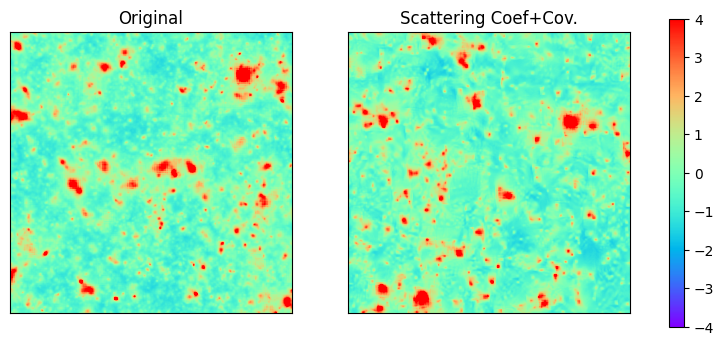

In [47]:
plot_syn(image_target[0],image_syn_cov[0], title_syn='Scattering Coef+Cov.',vminmax=(-4,4), 
         colorbar=True, figsize=(10,4), cmap='rainbow')

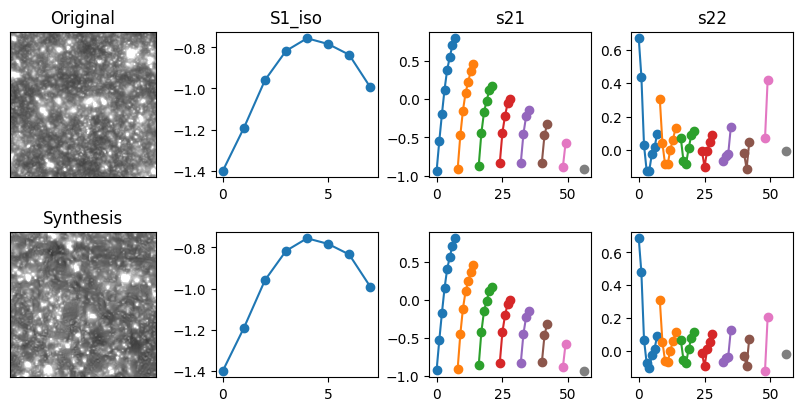

In [48]:
fig, ax = subplots(2,4,figsize=(8,4),layout='constrained')
for i,x in enumerate([image_target, image_syn_cov]):
  plot_coeffs(x,st_calc,ax=ax[i],coefs=['S1_iso','s21','s22'],title = True if i==0 else False)
  ax[i][0].set_title("Original" if i==0 else "Synthesis")

As we cas see not only by eyes but also on some statistics, the synthesis using scattering transfrom and taking into account the scale dependance is much better. Below is the same king of generation but using texture images.

# Texture synthesis

In [52]:
# in case of problem
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [53]:
images = ["D4.npy","D56.npy", 'D62.npy', 'D75.npy', 'bubble.npy']
all_imgs = []
for i,img_fn in enumerate(images):
    all_imgs.append(load(img_fn))

In [54]:
all_imgs = np.array(all_imgs)

In [55]:
image_targets = scattering.whiten(all_imgs)

In [56]:
image_syns = scattering.synthesis('s_cov', image_targets, seed=1)

input_size:  (5, 512, 512)
JEC: s in estimator
# of estimators:  16577
max residual:  8.734534740447998 , mean residual:  0.014643236878205752
max residual:  0.04617220163345337 , mean residual:  0.0004327926573033501
time used:  268.8374741077423 s


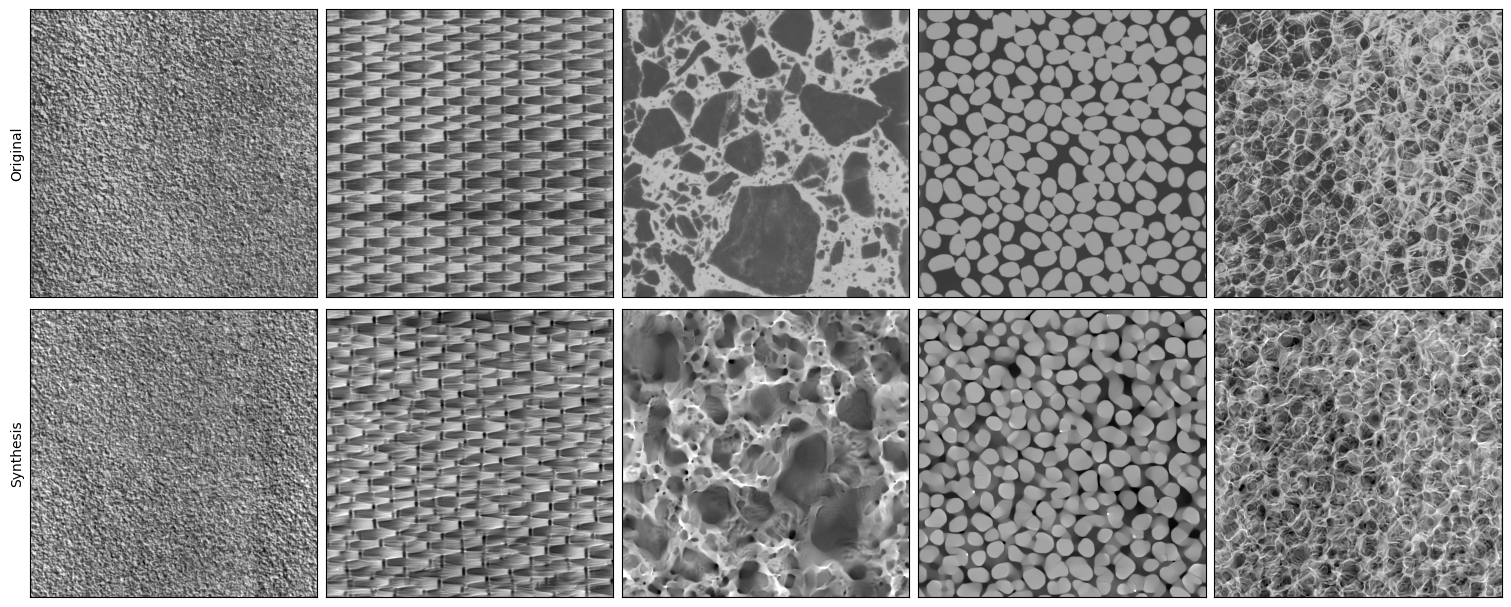

In [57]:
ncols = image_targets.shape[0]
fig, axs = plt.subplots(2,ncols, figsize=(3*ncols, 6), sharex=True, sharey=True,layout='constrained')
i=0
imgs=[]
for image_target,image_syn in zip(image_targets,image_syns):
    #image_target = scattering.filter_radial(image_target, lambda k: (k > 2) & (k <= 100))
    #image_syn = scattering.filter_radial(image_syn, lambda k: (k > 2) & (k <= 100))
    vmin = image_target.mean() - 3*image_target.std()
    vmax = image_target.mean() + 3*image_target.std()
    #print(vmin,vmax) # -3,3
    img = axs[0,i].imshow(image_target, vmin=vmin, vmax=vmax, cmap='gray'); 
    imgs.append(img)
    axs[0,i].set_xticks([]); axs[0,i].set_yticks([])
    axs[1,i].imshow(image_syn, vmin=vmin, vmax=vmax, cmap='gray'); #axs[i,1].set_title("Synthetized");
    axs[1,i].set_xticks([]); axs[1,i].set_yticks([])
    i+=1
    
axs[0,0].set_ylabel("Original");
axs[1,0].set_ylabel("Synthesis");